In [1]:
import pandas as pd
import numpy as np
import copy
import random
import math
from __future__ import division
from __future__ import with_statement
import minimization as minz #My script in same folder for minimization routines
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

Import all data available (very useful for any other plot)

In [29]:
n_rounds = 50
n_parents = 20

#Treatments and runs have to be the same lenght (one list per treatment)
n_signals_list = [0,0,1,1,0,1] #corresponding to each treatment in treatments (keep same order)
n_states_list = [8,8,8,8,8,8]
N_list = [40,40,40,40,40,40]
treatments = ['nosignal','nosignalsuperlong','signalce','signalcesuperlong','70to72k_nosignalsuperlong','useless_signal_test'] #outputmodifier+clue
runs = [[1,2,3,4,5,6],[1,2],[1,2,3,4,5],[1,2],[1,2],['']] #runs for each treatment. Each list has the runs to include for the corresponding treatment\
                         #(in same order as 'treatments')
info = {'summary':'summ','epochs_av':'ep', 'epochs_jm':'epj', 'jm':'jmachines'} #a shorter name for each type of data


folder = "/Users/luisalejandrolee/Dropbox/Thesis Phd/\
Coordination autos Chapter three/outputs_from_python/" #Python (minimization) outputs in this folder

folder_figs = "/Users/luisalejandrolee/Dropbox/Thesis Phd/Coordination autos Chapter three/figures_from_python/"
save_fig_type = '.png'
def import_epochs_epochsjm_jointmachines_summary(treatments, runs, info, folder,\
                                    n_states , n_signals, n_rounds, N, n_parents):
    
    data = {} #dictionary will contain all dataframes imported
    for pos,treatment in enumerate(treatments): #all treatments
        n_signals = n_signals_list[pos]
        n_states = n_states_list[pos]
        N = N_list[pos]
        for run in runs[pos]: #runs per treatment
            clue= treatment+str(run) #runs
            for info_name, info_variable in info.iteritems():#example: infoname=epochs_av, info_variable=ep
                
                inf = (info_name, clue, n_states , n_signals, n_rounds, N, n_parents)
                try:
                    import_file = folder+'%s_%s_states_%s_signal_%s_rounds_%s_N_%s_parents_%s.txt'%inf
                    #print import_file
                    df = pd.read_csv(import_file)
                    df = df.drop('Unnamed: 0',1)
                    data['%s%s_%s'%(treatments[pos], run, info_variable)] = df #add to dataframe to data dictionary

                    #print '%s%s_%s imported\n'%(treatments[pos], run, info_variable)
                except IOError:
                    pass
                    #print '%s%s_%s NOT FOUND. (File: %s\n'%(treatments[pos], run, info_variable, import_file)
    return data

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)
len(data)

52

#Total epochs and Frequency
Wrangle data for total epoch frequency 

In [131]:
#For panel 1
var = ['nosignalsuperlong2','signalcesuperlong2','useless_signal_test']
treatment_names = ['No Signal','Signal', 'Useless Signal']
total_category = 'Total Epochs'

#Next loop saves in 'series' a list for each var. The latter contains (100,000 or the length of the run) dummies
#with 1 in position i, if generation i was an epoch change (zero otherwise)

series=[None]*len(var) #to store time series
for i,v in enumerate(var): #all vars selected
    name_sum='%s_summ'%v #name for retrieving imported data as data[name].Summ for summary
    name_ep='%s_ep'%v #ep for epochs
    
    ends = list(data[name_ep].end) #generations where an epoch ended
    length=len(data[name_sum].index) #length of one run
    
    dummy_ends = [1 if gen in ends else 0 for gen in xrange(1,length+1)] #1 if in that generation an epoch ends
    series[i]=dummy_ends #save in series list

#Concatenate series corresponding to each treatment, and store them in dataframe
df = pd.DataFrame({treatment_names[0]: series[0], treatment_names[1]: series[1],treatment_names[2]: series[2]})

#Counts is main variable to plot
counts = df.mean()*len(df) #means*total gens (to show total number of epoch changes instead of very low percentages)

#Some arragements to count (which is a series). I prefer the plot as a dataframe, for aesthetic reasons.
counts_df = pd.DataFrame(counts).transpose() #index as columns
counts_df.index = [total_category]

#Confidence intervals
ci = stats.sem(df)*len(df) #get confidence interval at 95% assuming normal distribution

#Some arragements to count (which is a series). I prefer the plot as a dataframe, for aesthetic reasons.
ci_df = pd.DataFrame(ci).transpose() #index as columns
ci_df.index = [total_category]
ci_df.columns = [df.columns]




Wrangle data for frequency per regime

In [132]:
#For panel 2

#Organise data frame for frequency of epochs
#Two blocks of data, one for no signal(e.g. treatment 1) and the other for signal (e.g. treatment 2)
#Here is two runs per treatment. If wanna use only one run, replace one data with =[None]

ns =data['nosignalsuperlong2_ep'] #ns2=[None] to use only one data set (for reusability of code later)
s = data['signalcesuperlong2_ep']
us = data['useless_signal_test_ep']

title = 'Frequency of Epochs, Signal vs. No Signal\n2 runs of 100,000 generations per treatment'
panel1title='Frequency Percentage'
panel2title='Total Epoch changes'

######################################

#Have statistics by Domination and Biased, irrespective of whether is one population or the other dominating
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]

s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]

us.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in us.epoch[:]]


dum_ns = pd.get_dummies(ns['epoch']) #Dummies dataframe (categories are the regimes). One df per treatment
dum_s = pd.get_dummies(s['epoch'])
dum_us = pd.get_dummies(us['epoch'])
dum_us['Other']=0   #Three lines to make dum_us having the same order as the others. This one didn't have any "other" regime
cols=['Biased_Turn','Domination','Other','Turn_Taking']
dum_us.reindex(columns=cols)

mean_ns = dum_ns.mean() #Mean of the dummies is what is plotted (i.e. percentage of each category)
mean_s = dum_s.mean()
mean_us = dum_us.mean()

ci_ns = stats.sem(dum_ns) #Standard error of the mean. For error bars
ci_s = stats.sem(dum_s)
ci_us = stats.sem(dum_us)


means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s, 'Useless Signal': mean_us})#Get means in a single dataframe for easy plotting
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s, 'Useless Signal':ci_us})#get confidence interval in a single dataframe

ci.index=means.index[:] #very rough way to have the index for ci. Could be done better. Means and ci must have
                        #same index and in the same order at this point, so they correspond accordingly.

In [138]:
ci

,No Signal,Signal,Useless Signal
Biased_Turn,0.019664,0.054564,0.015978
Domination,0.032578,0.074955,0.048915
Other,0.007967,0.028571,0.047748
Turn_Taking,0.027900,0.054564,0.000000


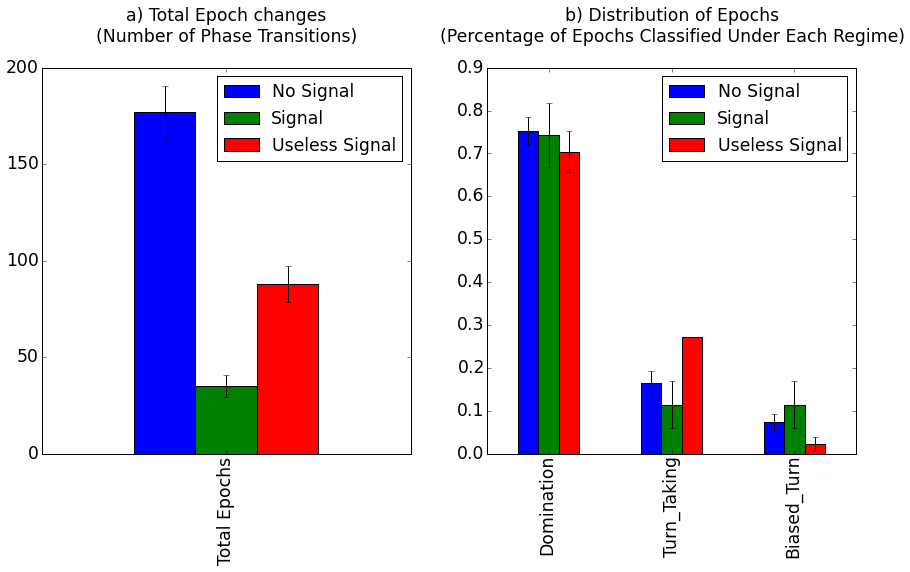

In [137]:
title = 'Frequency of Epochs\nOne long run (100,000 generations) per treatment'
panel1title='a) Total Epoch changes\n(Number of Phase Transitions)\n'
panel2title='b) Distribution of Epochs\n(Percentage of Epochs Classified Under Each Regime)\n'

#Define plots
fig=plt.figure()


#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.9)
fig.set_size_inches(13, 8) #size of the whole figure
ax1=plt.subplot(121)
plt.title(panel1title, fontsize='xx-large')
ax2=plt.subplot(122)
plt.title(panel2title, fontsize='xx-large')

counts_df.plot(kind='bar',yerr=ci_df,ax=ax1, fontsize='xx-large')#sorted means are plotted
means.drop('Other').sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax2, fontsize='xx-large')#sorted means are plotted
total = means * counts
#total['No Signal'] = means['No Signal'] * 100000
#total.drop('Other').sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax2)#sorted means are plotted
ax1.legend(['No Signal', 'Signal', 'Useless Signal'], fontsize='xx-large')
ax2.legend(['No Signal', 'Signal','Useless Signal'], fontsize='xx-large')

plt.tight_layout()
fig.savefig(folder_figs+'useless_signal_frequency_of_epochs'+save_fig_type, dpi = 100)

In [40]:
counts

No Signal    177
Signal        35
dtype: float64

In [19]:
ci

,No Signal,Signal
Biased_Turn,0.019664,0.054564
Domination,0.032578,0.074955
Other,0.007967,0.028571
Turn_Taking,0.027900,0.054564


In [20]:
means

,No Signal,Signal
Biased_Turn,0.073446,0.114286
Domination,0.751412,0.742857
Other,0.011299,0.028571
Turn_Taking,0.163842,0.114286


#Length of Epochs

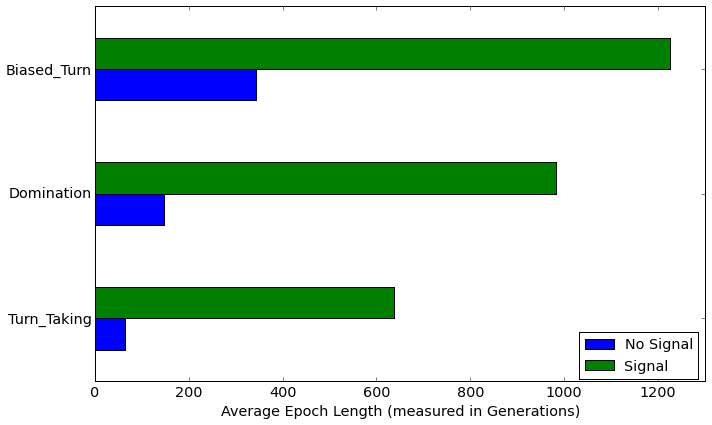

In [48]:
#Organise data frame for frequency of epochs
#Two blocks of data, one for no signal(e.g. treatment 1) and the other for signal (e.g. treatment 2)
#Here is two runs per treatment. If wanna use only one run, replace one data with =[None]

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns=data['nosignalsuperlong2_ep'] 
s = data['signalcesuperlong2_ep']

title = 'Length of Epochs per Regime\n2 runs of 100,000 generations per treatment'


######################################

#ns = ns1.append(ns2, ignore_index=True).drop(['start','end'],1) #Append datasets for the same treatment, dropping some columns
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]
#s = s1.append(s2, ignore_index=True)
s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]

#All this plot is the same as the one for frequencies percentages. The difference is next block:
#Instead of 'pivoting' the table to have a dummy for each category (as .get_dummy() does), here I use
#a normal pivoting to keep the values of 'duration'.
ns_p = pd.pivot_table(ns, index=ns.index, columns='epoch',values='duration').drop('Other',1)
s_p = pd.pivot_table(s, index=s.index, columns='epoch',values='duration').drop('Other',1)
#Replace NaN values with zero to calculate means
ns_p=ns_p.fillna(0)
s_p=s_p.fillna(0)
#######

mean_ns = ns_p.mean()
mean_s = s_p.mean()

ci_ns = stats.sem(ns_p)
ci_s = stats.sem(s_p)

means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s})
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s})#get confidence interval in a single dataframe
ci.index=means.index[:]

#Define plots
fig=plt.figure()
#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(10, 6) #size of the whole figure
ax1=plt.subplot(111)
ax1.set_xlabel('Average Epoch Length (measured in Generations)',fontsize='x-large')



#means.sort('No Signal').plot(kind='barh',xerr=ci,ax=ax1)#sorted means are plotted
means.index.names = ['']
means.sort('No Signal').plot(kind='barh',ax=ax1, fontsize='x-large')#sorted means are plotted

ax1.set_xlim([0,1300])
ax1.legend(bbox_to_anchor=(1, 0.15), fontsize='x-large')


plt.tight_layout()
fig.savefig(folder_figs+'length_of_epochs'+save_fig_type, dpi = 100)

In [45]:

means

,No Signal,Signal
,,
Biased_Turn,343.073446,1225.857143
Domination,146.920904,982.285714
Turn_Taking,63.988701,638.028571


#Probability of randomly choosing one generation, and it being each epoch

In [8]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns = data['nosignalsuperlong2_summ']['regime_av']
s = data['signalcesuperlong2_summ']['regime_av']

df = pd.DataFrame({'No signal':[],'Signal':[]})

In [9]:
df['ones_signal'] = [1]*len(ns)
df['ones_nosignal'] = [1]*len(ns)

In [10]:
df['No Signal'] = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
                   ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
                   for x in ns[:]]

df['Signal'] = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
                   ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
                   for x in s[:]]
df

,No signal,Signal,ones_signal,ones_nosignal,No Signal
0,NaN,Other,1,1,Other
1,NaN,Other,1,1,Other
2,NaN,Other,1,1,Other
3,NaN,Other,1,1,Domination
4,NaN,Other,1,1,Domination
5,NaN,Other,1,1,Domination
6,NaN,Domination,1,1,Domination
7,NaN,Domination,1,1,Domination
8,NaN,Domination,1,1,Domination
9,NaN,Domination,1,1,Domination


In [11]:
a = df['ones_nosignal'].groupby(df['No Signal']).count()

In [12]:
b = df['ones_signal'].groupby(df['Signal']).count()

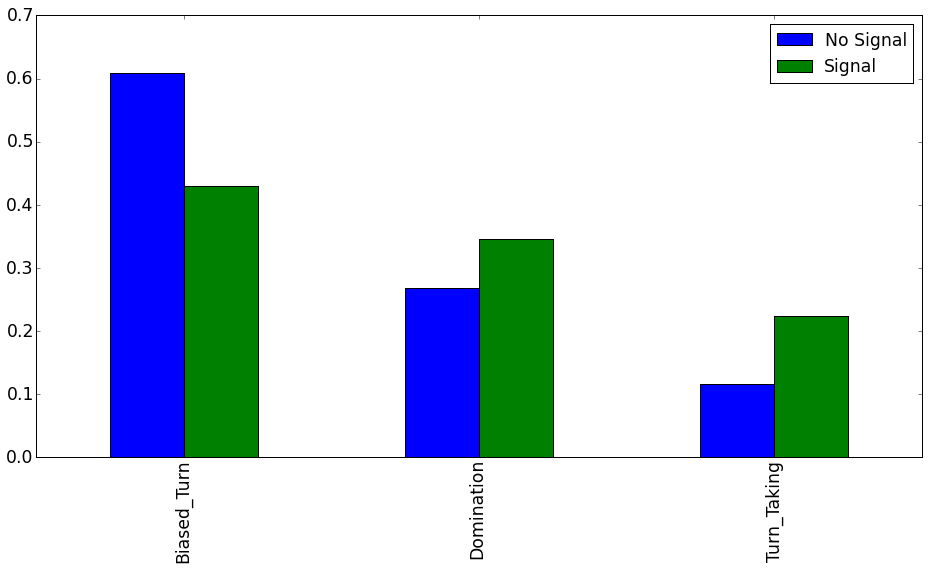

In [31]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns = pd.DataFrame(data['nosignalsuperlong2_summ']['regime_av'])
ns.columns = ['epoch']
s = pd.DataFrame(data['signalcesuperlong2_summ']['regime_av'])
s.columns = ['epoch']
title = 'Prob of each epoch'

######################################

#ns = ns1.append(ns2, ignore_index=True).drop(['start','end'],1) #Append datasets for the same treatment, dropping some columns
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]
#s = s1.append(s2, ignore_index=True)
s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]

dum_ns = pd.get_dummies(ns['epoch']) #Dummies dataframe (categories are the regimes). One df per treatment
dum_s = pd.get_dummies(s['epoch'])

mean_ns = dum_ns.mean() #Mean of the dummies is what is plotted (i.e. percentage of each category)
mean_s = dum_s.mean()

ci_ns = stats.sem(dum_ns) #Standard error of the mean. For error bars
ci_s = stats.sem(dum_s)

means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s})#Get means in a single dataframe for easy plotting
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s})#get confidence interval in a single dataframe

ci.index=means.index[:] #very rough way to have the index for ci. Could be done better. Means and ci must have
                        #same index and in the same order at this point, so they correspond accordingly.
fig=plt.figure()


#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(13, 8) #size of the whole figure
ax1=plt.subplot(111)



#means.drop('Other').sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax1)#sorted means are plotted
means.drop('Other').sort('No Signal', ascending=False).plot(kind='bar', ax=ax1, fontsize='xx-large')#sorted means are plotted
ax1.legend(['No Signal', 'Signal'], fontsize='xx-large')
#means.sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax1)#sorted means are plotted

fig.tight_layout()
fig.savefig(folder_figs+'probability_of_regimes'+save_fig_type, dpi = 100)

In [14]:
means.sort('No Signal', ascending=False)

,No Signal,Signal
Biased_Turn,0.60923,0.42915
Domination,0.26782,0.34538
Turn_Taking,0.11615,0.22432
Other,0.00680,0.00115


In [15]:
plt.close()

#Two super long simulations, Signal and No-Signal

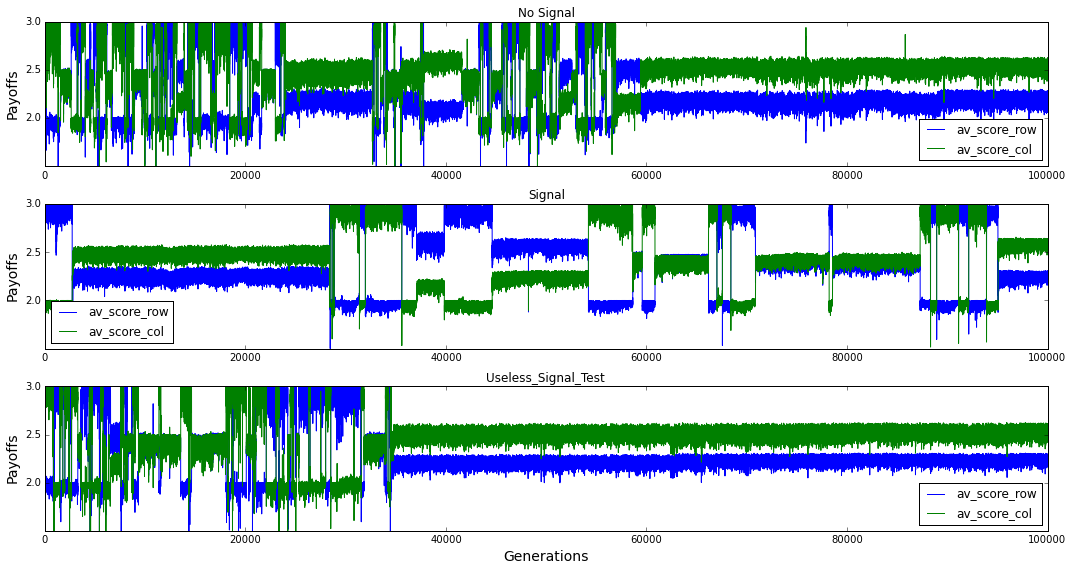

In [33]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

fig=plt.figure()
fig.set_size_inches(15, 8) #size of the whole figure
ax1=plt.subplot(311)
ax1.set_title('No Signal')
ax1.set_ylabel('Payoffs',fontsize=14)
ax1.set_ylim([1.5,3])
ax1.set_yticks([2, 2.5, 3])
data['nosignalsuperlong2_summ'][['av_score_row','av_score_col']].plot(ax=ax1, label="None")

ax2=plt.subplot(312)
ax2.set_title('Signal')
#ax2.set_xlabel('Generations',fontsize=14)
ax2.set_ylabel('Payoffs',fontsize=14)
ax2.set_ylim([1.5,3])
ax2.set_yticks([2, 2.5, 3])
data['signalcesuperlong2_summ'][['av_score_row','av_score_col']].plot(ax=ax2)

ax3=plt.subplot(313)
ax3.set_title('Useless_Signal_Test')
ax3.set_xlabel('Generations',fontsize=14)
ax3.set_ylabel('Payoffs',fontsize=14)
ax3.set_ylim([1.5,3])
ax3.set_yticks([2, 2.5, 3])
data['useless_signal_test_summ'][['av_score_row','av_score_col']].plot(ax=ax3)

fig.tight_layout()
fig.savefig(folder_figs+'uselss_signal_payoffs_comparison'+save_fig_type, dpi = 100)




In [13]:
data['useless_signal_test_summ']

KeyError: 'useless_signal_test_summ'

For simple graph on average payoffs (used to be done in other file, but now seems easier here)

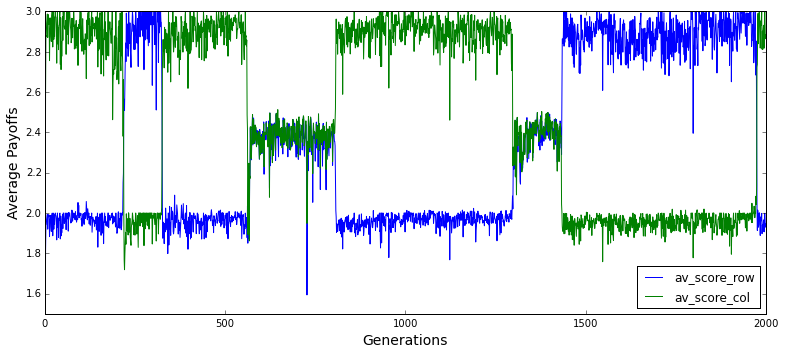

In [32]:


data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)



fig=plt.figure()
#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(11, 5) #size of the whole figure
ax1=plt.subplot(111)
data['nosignal5_summ'][['av_score_row','av_score_col']].plot(ax=ax1)
ax1.set_ylim([1.5,3])
ax1.set_xlabel('Generations',fontsize=14)
ax1.set_ylabel('Average Payoffs',fontsize=14)

plt.tight_layout()
fig.savefig(folder_figs+'payoffs_one_run_no_signal'+save_fig_type, dpi = 100)

#CE Measure vs Payoffs

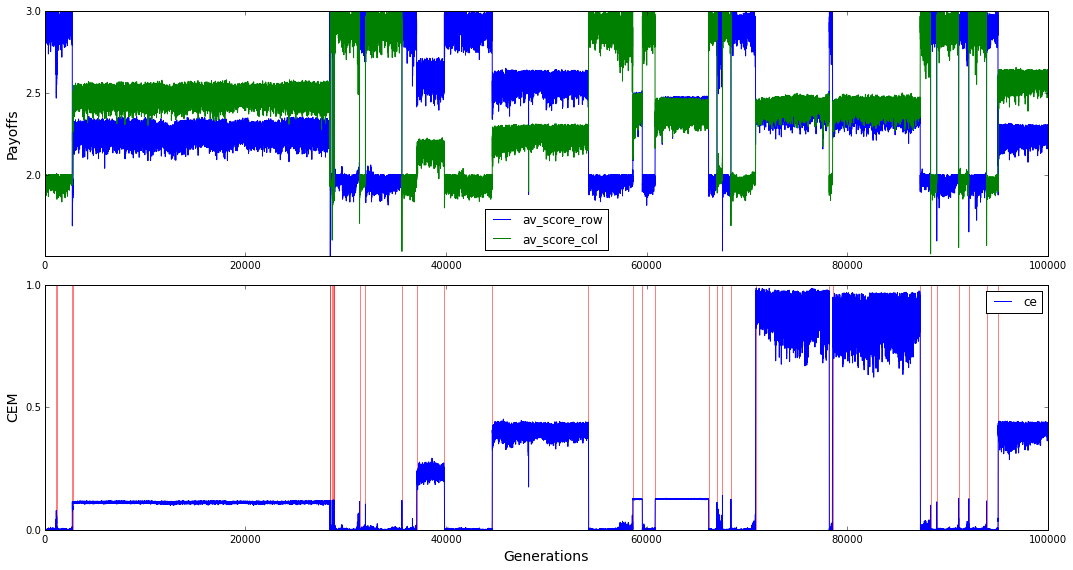

In [53]:
#data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
#                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)



fig=plt.figure()
fig.set_size_inches(15, 8) #size of the whole figure
ax1=plt.subplot(211)
#ax1.set_title('No Signal')
ax1.set_ylabel('Payoffs',fontsize=14)
ax1.set_ylim([1.5,3])
ax1.set_yticks([2, 2.5, 3])
data['signalcesuperlong2_summ'][['av_score_row','av_score_col']].plot(ax=ax1)
h_values = data['signalcesuperlong2_ep']['end']
for v in h_values:
    plt.vlines(v,0,1,linewidth=3, color='r')


ax2=plt.subplot(212)
#ax2.set_title('Signal')
ax2.set_xlabel('Generations',fontsize=14)
ax2.set_ylabel('CEM',fontsize=14)
ax2.set_ylim([0,1])
ax2.set_yticks([0, 0.5, 1])
data['signalcesuperlong2_summ'][['ce']].plot(ax=ax2)
h_values = data['signalcesuperlong2_ep']['end']
for v in h_values:
    plt.vlines(v,0,1,linewidth=0.5, color='r')

fig.tight_layout()
fig.savefig(folder_figs+'CEM_vs_payoffs'+save_fig_type, dpi = 100)



In [48]:
h_values

0       1141
1       1180
2       2741
3       2767
4      28391
5      28463
6      28654
7      28781
8      28812
9      28856
10     31379
11     31972
12     35604
13     37072
14     39842
15     44613
16     54211
17     58625
18     59573
19     60848
20     66182
21     67019
22     67569
23     68414
24     70865
25     78213
26     78544
27     87289
28     88321
29     88932
30     91115
31     92129
32     93902
33     95052
34    100000
Name: end, dtype: float64

#CE Measure

In [14]:
#Can only use the second super long run because the first one has a bug: name 'ce' is ' ce' (I think 
#that's the bug, but couldn't trace it down). So would have to run
#one new simulation (superlong) to have two sims. One should do fine

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

summ =data['signalcesuperlong2_summ'] 
ep = data['signalcesuperlong2_ep']

#Add the 'ce' column to epochs dataframe, containing the average CE for that particular epoch
ce_list = []
for i in ep.index[:]:
    start = int(ep['start'][i])
    end = int(ep['end'][i])
    ce_range = summ['ce'][start:end]
    ce_list.append(ce_range.mean())
ep['ce'] = ce_list

#"see", or filter to observe how many turntaking were there, with their corresponding ce measure
#go and run a couple of gens for those epochs to get the joint machines

In [15]:
ep[(ep.epoch!='Domination_AA') & (ep.epoch!='Domination_BB') & (ep.epoch!='Other')]

,epoch,duration,start,end,ce
4,Biased_Turn_A,25617,2774,28391,0.112274
14,Biased_Turn_B,2762,37080,39842,0.233776
16,Biased_Turn_B,9590,44621,54211,0.405229
18,Turn_Taking,936,58637,59573,0.124782
20,Turn_Taking,5326,60856,66182,0.125341
25,Turn_Taking,7336,70877,78213,0.884996
27,Turn_Taking,8733,78556,87289,0.853684
34,Biased_Turn_A,4936,95064,100000,0.401399


In [16]:
ep

,epoch,duration,start,end,ce
0,Domination_BB,1128,13,1141,0.001572
1,Domination_BB,28,1152,1180,0.025903
2,Domination_BB,1550,1191,2741,0.000858
3,Other,17,2750,2767,0.081688
4,Biased_Turn_A,25617,2774,28391,0.112274
5,Domination_BB,57,28406,28463,0.005440
6,Domination_AA,178,28476,28654,0.001988
7,Domination_BB,115,28666,28781,0.001209
8,Domination_AA,22,28790,28812,0.002914
9,Domination_BB,35,28821,28856,0.002748


#Miscoordination and average payoffs calculations

In [71]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)



In [73]:
signal = data['signalcesuperlong2_summ']
no_signal = data['nosignalsuperlong2_summ']

In [110]:
signal['av_score_col'].mean()

2.435024555374975

In [112]:
no_signal['av_score_row'].mean()

2.259464486124968

In [101]:
signal['miscoordination_perc'].mean()

0.0383106757500005

In [102]:
no_signal['miscoordination_perc'].mean()

0.05119047037499944

In [100]:
signal

,generation,av_score_row,av_score_col,miscoordination_perc,coordination_B_perc,coordination_A_perc,row_heads_A,row_heads_B,row_tails_A,row_tails_B,col_heads_A,col_heads_B,col_tails_A,col_tails_B,times_heads,times_tails,ce,regime_av
0,0,1.302550,1.263450,0.486800,0.276150,0.237050,17506,22536,19916,20002,19895,20145,19515,20405,40042,39918,0.124701,Other
1,1,1.056612,1.109200,0.566837,0.190287,0.242875,10869,28976,15127,25028,28652,11201,29559,10588,39845,40155,0.088928,Other
2,2,1.351613,1.370513,0.455575,0.262763,0.281662,14168,25990,19137,20705,23843,16313,24364,15480,40158,39842,0.119516,Other
3,3,1.354550,1.516450,0.425800,0.206150,0.368050,14803,25203,20587,19407,28517,11495,29045,10943,40006,39994,0.102688,Other
4,4,1.756025,1.675787,0.313638,0.383300,0.303063,11080,28750,18075,22095,21598,18226,22828,17348,39830,40170,0.120292,Other
5,5,2.333438,1.843687,0.164575,0.662587,0.172838,5254,34902,10390,29454,12252,27910,12924,26914,40156,39844,0.071031,Other
6,6,2.988837,1.993600,0.003512,0.995862,0.000625,60,39901,91,39948,33,39941,197,39829,39961,40039,0.000012,Domination_BB
7,7,2.921650,1.956975,0.024275,0.970200,0.005525,693,39271,730,39306,252,39706,1151,38891,39964,40036,0.000616,Domination_BB
8,8,2.929425,1.959825,0.022150,0.973725,0.004125,665,39318,527,39490,508,39473,732,39287,39983,40017,0.000439,Domination_BB
9,9,2.977737,1.985950,0.007262,0.992263,0.000475,205,39699,142,39954,49,39858,261,39832,39904,40096,0.000029,Domination_BB


In [13]:
def myfunction(a):
    print a

In [14]:
myfunction ('adfs')

adfs


#Two-worlds-test Figure

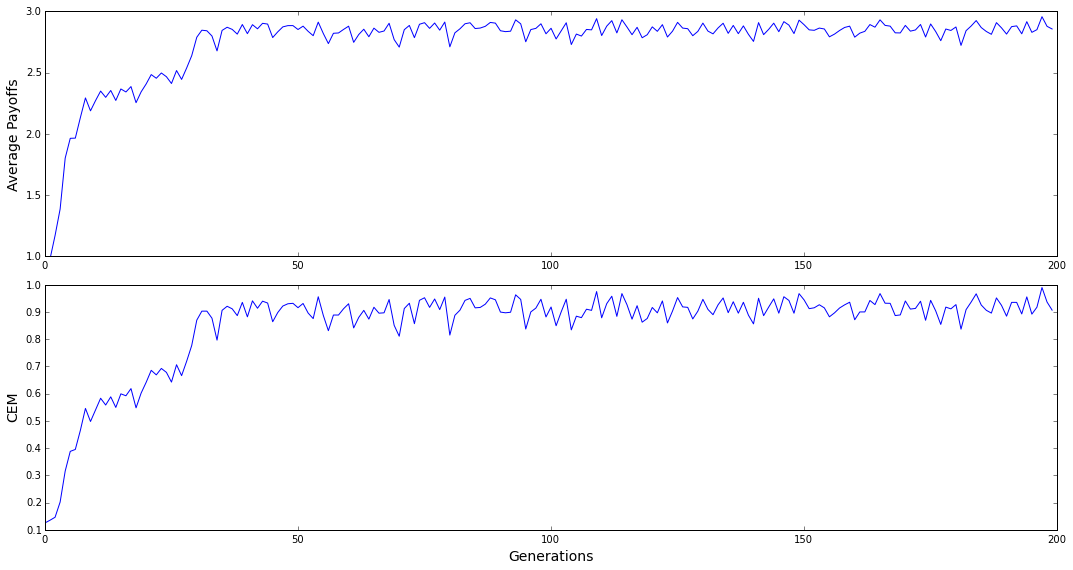

In [32]:
#Make plot here
test_file ="/Users/luisalejandrolee/Dropbox/Thesis Phd/\
Coordination autos Chapter three/outputs_from_netlogo/\
summary_two_worlds_test_states_8_signal_1_rounds_50_N_40_parents_20.txt" #Python (minimization) outputs in this folder

data = pd.read_csv(test_file)

fig=plt.figure()
fig.set_size_inches(15, 8) #size of the whole figure
ax1=plt.subplot(211)
#ax1.set_title('No Signal')
ax1.set_ylabel('Average Payoffs',fontsize=14)
ax1.set_ylim([1,3])
ax1.set_yticks([1, 1.5, 2, 2.5, 3])
#data[['av_score_row','ce']].plot(ax=ax1)
line1 = data['av_score_row']
line2 = data['ce']
ax1.plot(line1, label='A')

ax2=plt.subplot(212)
ax2.plot(line2, label='BBBBBBB')
ax2.set_ylabel('CEM',fontsize=14)
ax2.set_xlabel('Generations',fontsize=14)
plt.axhline(y=1, linewidth=0.3, color='black')

fig.tight_layout()
fig.savefig(folder_figs+'two_worlds_test_payoffs_vs_CEM'+save_fig_type, dpi = 100)

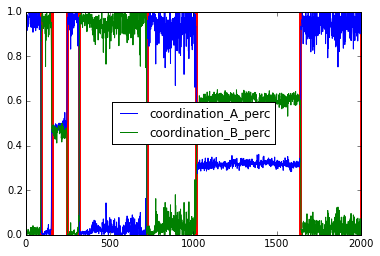

In [17]:
data['nosignal6_summ'][['coordination_A_perc','coordination_B_perc']].plot()
h_values = data['nosignal6_ep']['end']
for v in h_values:
    plt.vlines(v,0,1,linewidth=3, color='r')

In [18]:
#Useful lines (not part of the code, but just to copy easily)

#Basic for a plot
data=[3,2,10]
fig,ax=plt.subplots(2,2,squeeze=False,sharex=True,sharey=True)
ax[0][0].plot(data)
ax[1][1].plot(data)
plt.close()



plt.vlines(x, ymin, ymax) #horizontal and vertical lines
plt.hlines(y, xmin, xmax)

#ax is the name of the plot. If used fig, axes = plt.subplot(2,2) to create several, they can be indexed
ax.set_yscale('log') #some regularly useful 'set' functions
ax.set_xlim([0,10])
ax.set_xlabel('some label')

fig.tight_layout() #avoids overlapping of axis ticks

#small code for adding several vertical lines in a particular plot (first make the relevant figure to be current)
h_values = [200, 300, 400]
for v in h_values:
    axes[0][0].vlines(v,0,3,linewidth=5, color='r')

axes[0][0].set_title('5 Simulations, No signal')
axes[0][0].set_xlabel('Generations')
axes[0][0].set_ylabel('Average Payoffs')

#To save
plt.savefig('foo.png', bbox_inches='tight')
fig.savefig('path/to/save/image/to.png')


NameError: name 'Ture' is not defined

#Percentage of coordination A and B
##Signal

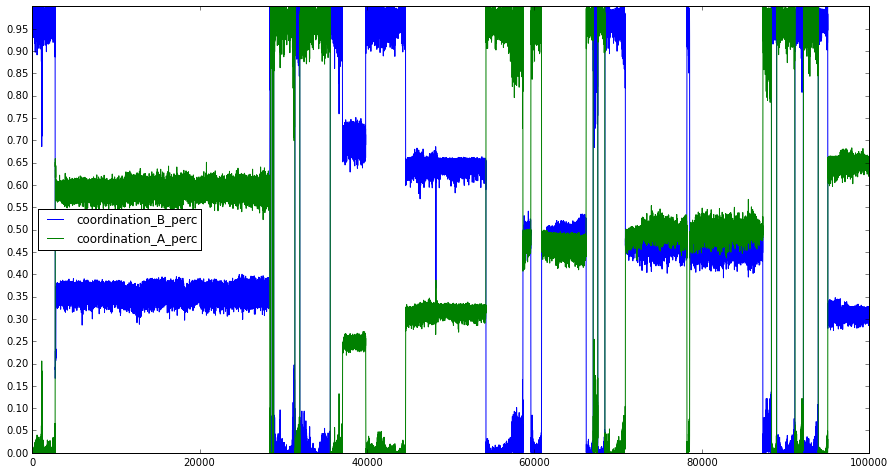

In [19]:
#Can only use the second super long run because the first one has a bug: name 'ce' is ' ce' (I think 
#that's the bug, but couldn't trace it down). So would have to run
#one new simulation (superlong) to have two sims. One should do fine

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

summ =data['signalcesuperlong2_summ'] 
ep = data['signalcesuperlong2_ep']

fig=plt.figure()
#fig.suptitle(title,fontsize=20)
fig.set_size_inches(15, 8) #size of the whole figure
ax1=plt.subplot(111)
ax1.set_yticks(np.arange(0, 1, 0.05))
summ[['coordination_B_perc', "coordination_A_perc"]].plot(ax=ax1)



##No Signal

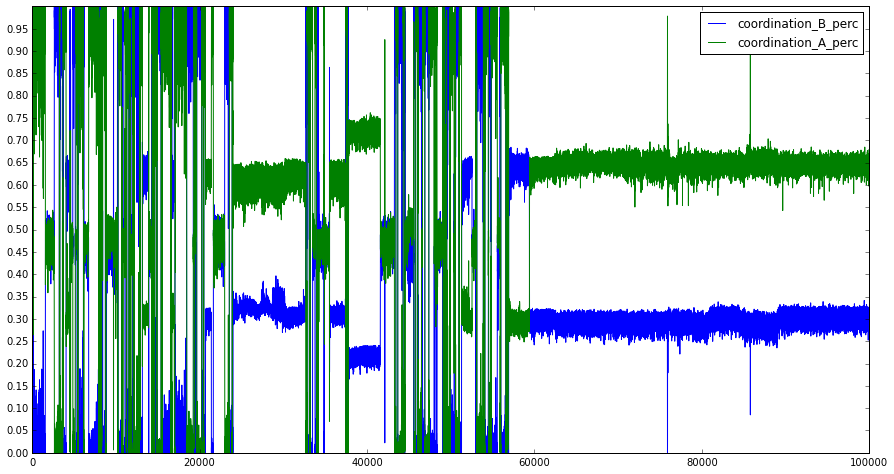

In [18]:
#Can only use the second super long run because the first one has a bug: name 'ce' is ' ce' (I think 
#that's the bug, but couldn't trace it down). So would have to run
#one new simulation (superlong) to have two sims. One should do fine

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

summ =data['nosignalsuperlong2_summ'] 

fig=plt.figure()
#fig.suptitle(title,fontsize=20)
fig.set_size_inches(15, 8) #size of the whole figure
ax1=plt.subplot(111)
ax1.set_yticks(np.arange(0, 1, 0.05))
summ[['coordination_B_perc', "coordination_A_perc"]].plot(ax=ax1)